<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Импорт-и-установки" data-toc-modified-id="Импорт-и-установки-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Импорт и установки</a></span></li><li><span><a href="#Функции" data-toc-modified-id="Функции-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Функции</a></span></li><li><span><a href="#Настройки" data-toc-modified-id="Настройки-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Настройки</a></span></li><li><span><a href="#Чтение-данных" data-toc-modified-id="Чтение-данных-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чтение данных</a></span></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Без-BERT" data-toc-modified-id="Без-BERT-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Без BERT</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Импорт и установки

In [1]:
import pandas as pd
import numpy as np
import re

import warnings
import time

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import plotly.graph_objects as go
import plotly.io as pio
from mpl_toolkits.mplot3d import Axes3D

import nltk
from nltk.corpus import stopwords  
import spacy
from tqdm.notebook import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer, classification_report
from sklearn.pipeline import Pipeline

from catboost import CatBoostClassifier

from transformers import BertTokenizer, BertForSequenceClassification, AdamW

from torch.utils.data import DataLoader, Dataset
import torch

## Функции

In [2]:
# Function to Get Data Information

def explore_dataframe(df):
#     # Shape
#     shape_info = pd.DataFrame({"Shape of dataframe": [f"Total: {df.shape[0]} rows, {df.shape[1]} columns"]})
#     shape_info = shape_info.replace(np.nan, "-")
    
    # Data Types
    data_types_info = df.dtypes.to_frame().reset_index().rename(columns={"index": "Тип данных", 0: ""})
    
    # Missing Values
    missing_values_info = df.isnull().sum().to_frame().reset_index().rename(columns={"index": "Пропущенные значения", 0: ""})
    missing_values_info["Пропущенные значения"] = missing_values_info["Пропущенные значения"].fillna("-")
    
    # Duplicate Rows
    duplicate_rows_info = pd.DataFrame({"Дубликаты значений": [f"Всего: {df.duplicated().sum()}"]})
    duplicate_rows_info = duplicate_rows_info.replace(np.nan, "-")
    
     # Unique Values
    unique_values_info = df.nunique().to_frame().reset_index().rename(columns={"index": "Столбец", 0: "Уникальных значений"})
    
    # Describe
    describe_info = df.describe().transpose().reset_index().rename(columns={"index": "Столбец"})

    # Concatenate tables
    info_table = pd.concat([data_types_info, missing_values_info, unique_values_info], axis=1) #shape_info, delite this for a while
    
    
    # Display tables
    display(df.sample())
    display(df.describe())  
    display(info_table)

## Настройки

In [3]:
# TextStyle

class f:    
    BOLD = "\033[1m"     # Bold text
    ITALIC = "\033[3m"   # Italic text
    END = "\033[0m"      # Reset style

In [4]:
# Matplotlib, Seaborn

PLOT_DPI = 150 # dpi for drawing charts
sns.set_style('whitegrid', {'axes.facecolor': '0.98', 'grid.color': '0.9', 'axes.edgecolor': '1.0'})
plt.rc('axes', labelweight='bold', titlesize=16, titlepad=10)

# Plotly Graph_Objects
pio.templates['my_theme'] = go.layout.Template(
    layout_autosize=True,
    layout_height=200,
    layout_legend_orientation="h",
    layout_margin=dict(t=40, b=40),
    layout_template='seaborn'
)
pio.templates.default = 'my_theme'

# colors, color schemes
CMAP_SYMMETRIC = LinearSegmentedColormap.from_list('', ['gray', 'steelblue', 'hotpink'])

In [5]:
# Pandas defaults

pd.options.display.max_colwidth = 100
pd.options.display.max_rows = 500
pd.options.display.max_columns = 100
pd.options.display.float_format = '{:.3f}'.format
pd.options.display.colheader_justify = 'left'

In [6]:
# Disable warnings

warnings.filterwarnings('ignore')

## Чтение данных

In [7]:
data = pd.read_csv('/datasets/toxic_comments.csv',index_col=0)

In [8]:
explore_dataframe(data)

,text,toxic
42274,"Look, I'm a lawyer and historian by occupation, and heraldry is my hoby. As in most european sta...",0


,toxic
count,159292.000
mean,0.102
std,0.302
min,0.000
25%,0.000
50%,0.000
75%,0.000
max,1.000


,Тип данных,,Пропущенные значения,,Столбец,Уникальных значений
0,text,object,text,0,text,159292
1,toxic,int64,toxic,0,toxic,2


In [9]:
# Проверка баланса классов

data['toxic'].value_counts(normalize=True)

0   0.898
1   0.102
Name: toxic, dtype: float64

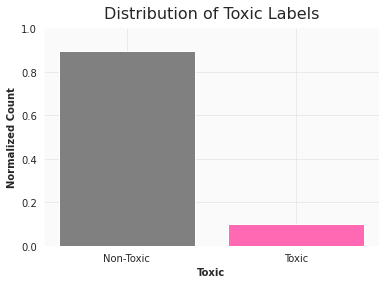

In [10]:
data_list = {
    0: 0.898,
    1: 0.102
}

colors = ['gray', 'hotpink']

plt.figure(figsize=(6, 4))
plt.bar(data_list.keys(), data_list.values(), color=colors)
plt.xlabel('Toxic')
plt.ylabel('Normalized Count')
plt.title('Distribution of Toxic Labels')
plt.xticks(list(data_list.keys()), ['Non-Toxic', 'Toxic'])
plt.ylim(0, 1) 
plt.show()

> Для исследования представлен датасет со 152 292 комментариями, пропущенных значений нет. В классах наблюдается дисбаланс. Негативных комментариев в разы меньше, чем позитивных или нейтральных

## Подготовка

In [11]:
data = data[['text', 'toxic']]

In [12]:
data['text'] = data['text'].str.lower()

In [13]:
data['text'] = data['text'].apply(lambda x: re.sub(r'[^a-zA-Z0-9]', ' ', x))

In [14]:
nltk.download('punkt')

data['text'] = data['text'].apply(lambda x: nltk.word_tokenize(x))

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [15]:
# nltk.download('stopwords')
# stop_words = set(stopwords.words('english'))
# data['text'] = data['text'].apply(lambda x: [word for word in x if word not in stop_words])

In [16]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [17]:
%%time

data['text'] = data['text'].apply(lambda x: [token.lemma_ for token in nlp(" ".join(x))])

CPU times: user 16min 46s, sys: 3.54 s, total: 16min 49s
Wall time: 16min 51s


In [18]:
%%time

# Объединение лемматизированных токенов обратно в предложения

data['text'] = data['text'].apply(lambda x: ' '.join(x))

CPU times: user 510 ms, sys: 3.99 ms, total: 514 ms
Wall time: 521 ms


> Оставляем в данных только столбцы `text` и `toxic`, удаляя все остальные. Это нужно, чтобы сосредоточить обучение на текстовых данных и целевой переменной  

> Приводим все текстовые данные в столбце `text` к нижнему регистру. Это нужно для того, чтобы учесть различия в регистре слов, например, чтобы слова "Toxic" и "toxic" рассматривались как одно и то же слово  

> Используем регулярные выражения для замены всех символов, кроме букв и цифр, на пробелы. Это помогает удалить все специальные символы и знаки пунктуации из текста  

> Загружаем пакет `punkt` из библиотеки `nltk`, который содержит предобученные токенизаторы. Этот пакет используется для токенизации текста на отдельные слова или токены. После чего, применяем токенизатор к каждому текстовому комментарию в столбце `text`  

> Загружаем пакет `stopwords` из библиотеки `nltk`. Этот пакет содержит стоп-слова, которые часто встречаются в текстах и не несут смысловой нагрузки. Они будут удалены из текста на следующем шаге и сохранены в переменную `stop_words`

> Применяем фильтрацию, чтобы удалить стоп-слова из каждого комментария. Используем лямбда-функцию внутри метода apply, чтобы отфильтровать только те слова, которых нет в списке стоп-слов  

> Применяем лемматизацию и объединяем токены обратно в текстовые комментарии, используя пробел в качестве разделителя. Это позволит представить обработанные тексты в виде строк для дальнейшей обработки и обучения моделей  

## Обучение

In [19]:
features = data['text']
target = data['toxic']

In [20]:
_, features_subsample, _, target_subsample = train_test_split(
    features, target, test_size=0.2, random_state=12345, stratify=target
)

In [21]:
# Разделение данных на обучающий и тестовый наборы

features_train, features_test, target_train, target_test = train_test_split(
    features_subsample, target_subsample, test_size=0.2, random_state=12345, stratify=target_subsample
)

In [22]:
print(f"Количество строк в y_train по классам: {np.bincount(target_train)}")
print(f"Количество строк в y_test по классам: {np.bincount(target_test)}")

Количество строк в y_train по классам: [22897  2590]
Количество строк в y_test по классам: [5725  647]


In [23]:
features_train.shape, features_test.shape, target_train.shape, target_test.shape 

((25487,), (6372,), (25487,), (6372,))

In [24]:
# TF-IDF векторизация

# count_tf_idf = TfidfVectorizer()

In [25]:
# Преобразование текста в матрицу  

# features_train = count_tf_idf.fit_transform(features_train.values)
# features_test = count_tf_idf.transform(features_test.values)

In [26]:
print(f'features_train:{features_train.shape}')
print(f'features_test:{features_test.shape}')

features_train:(25487,)
features_test:(6372,)


### Без BERT

In [27]:
logreg_model = LogisticRegression(random_state=12345)
pa_model = PassiveAggressiveClassifier(random_state=12345)

In [28]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words="english")), 
    ('clf', None)
])

In [29]:
param_grids = [
    {
        'tfidf__ngram_range': [(1, 1), (1, 2)],  # Для Logistic Regression
        'clf': [logreg_model],
        'clf__C': [1, 10, 100]
    },
    {
        'tfidf__ngram_range': [(1, 1), (1, 2)],  # Для Passive Aggressive Classifier
        'clf': [pa_model],
        'clf__C': [1, 10, 100]
    }
]


In [30]:
%%time

for param_grid in param_grids:
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        scoring=make_scorer(f1_score),
        cv=3
    )
    grid_search.fit(features_train, target_train)
    
    print(grid_search.best_params_)
    print(grid_search.best_score_)

{'clf': LogisticRegression(C=100, random_state=12345), 'clf__C': 100, 'tfidf__ngram_range': (1, 1)}
0.7257869338206547
{'clf': PassiveAggressiveClassifier(C=1, random_state=12345), 'clf__C': 1, 'tfidf__ngram_range': (1, 2)}
0.742958166694406
CPU times: user 5min 31s, sys: 5min 18s, total: 10min 50s
Wall time: 10min 51s


In [31]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [32]:
# Оценим модель на кросс-валидации

f1_scores_cv = grid_search.cv_results_['mean_test_score']
print('F1 на кросс-валидации:', f1_scores_cv)

F1 на кросс-валидации: [0.71919521 0.74295817 0.71164313 0.73797653 0.71164313 0.73797653]


In [33]:
# Оценим модель на тестовых данных (для финальной оценки)

predictions_test = best_model.predict(features_test)
f1_score_test = f1_score(target_test, predictions_test)
print(f'F1 метрика на тестовых данных: {f1_score_test}')

F1 метрика на тестовых данных: 0.7605150214592276


## Выводы

По условию исследования, мы должны получить модель с метрикой F1 не менее 0.75. Этим требованиям отвечают:  

* F1 метрика на valid данных (Логистическая регрессия): 0.77389811104751  
  F1 на кросс-валидации для Логистическая регрессия: 0.7596033708270826  
  
* F1 метрика на valid данных (CatBoost): 0.7626514611546685  
  F1 на кросс-валидации для CatBoost: 0.7412103714786276 (почти)  
  
Матрица ошибок также показала неплохие результаты для этих моделей. С учетом того, что в классах был дисбаланс мы могли бы улучшить способность модели предсказывать токсичные комментарии - дополнив их количество. Но сортировать комментарии на базе обучения положительными - также является вариантом выполнения поставленной задачи  